# import libraries 


In [2]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score , mean_squared_error
import numpy as np 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


# Load the dataset 

In [3]:
df = pd.read_csv("Gold Price (2013-2023).csv") 

# Clean numerical columns by removing commas and converting to float


In [4]:
columns = ["Price", "Open", "High", "Low"]
for col in columns:
    df[col] = df[col].replace({",": ""}, regex=True)
    df[col] = df[col].astype("float64")

# Convert Date format

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by="Date", ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df["date_year"] = df["Date"].dt.year
df["date_month"] = df["Date"].dt.month
df["date_day"] = df["Date"].dt.day

# Replace 'K' with '000' and convert 'Vol.' to float 

In [6]:
df['Vol.'] = df['Vol.'].str.replace("K", "000", regex=True)
df['Vol.'] = df['Vol.'].astype("float64")


# Remove '%' sign from 'Change %' and convert to float

df['Change %'] = df['Change %'].str.replace("%", "", regex=True)
df['Change %'] = df['Change %'].astype("float64")


In [7]:
# Assuming 'df' is your DataFrame and it's already loaded and preprocessed

cols_to_shift = ["Open", "High", "Low", 'Vol.', "Change %"]
df_shifted = df[['Date']].copy()

for col in cols_to_shift:
    df[f'Yesterday_{col}'] = df[col].shift(1)

df = df.merge(df_shifted, on='Date', how='left')

# Remove rows where the previous day's date does not match
df['Yesterday_Date'] = df['Date'].shift(1)
df = df[df['Date'] - pd.Timedelta(days=1) == df['Yesterday_Date']]

# Drop the temporary 'Yesterday_Date' column
df = df.drop(columns=['Yesterday_Date'])

# Drop the first row with NaN values due to shifting
df = df.dropna().reset_index(drop=True)

# Display the first few rows to verify the new columns
print(df.head())


        Date   Price    Open    High     Low  Vol.  Change %  date_year  \
0 2013-01-03  1675.6  1688.0  1689.3  1664.3  0.19     -0.85       2013   
1 2013-01-04  1649.9  1664.4  1664.4  1630.0  0.31     -1.53       2013   
2 2013-01-08  1663.2  1651.5  1662.6  1648.8  0.13      0.97       2013   
3 2013-01-09  1656.5  1660.7  1664.2  1652.3  0.16     -0.40       2013   
4 2013-01-10  1679.0  1656.7  1679.2  1656.7  0.14      1.36       2013   

   date_month  date_day  Yesterday_Open  Yesterday_High  Yesterday_Low  \
0           1         3          1675.8          1695.0         1672.1   
1           1         4          1688.0          1689.3         1664.3   
2           1         8          1657.3          1663.8         1645.3   
3           1         9          1651.5          1662.6         1648.8   
4           1        10          1660.7          1664.2         1652.3   

   Yesterday_Vol.  Yesterday_Change %  
0            0.06                0.78  
1            0.19       

# Clean numerical columns by removing commas and converting to float
  

In [8]:
columns = ["Yesterday_Open", "Yesterday_High", "Yesterday_Low", "Yesterday_Vol.", "Yesterday_Change %"]

for i in columns :
    df[i]=df[i].replace({",":""},regex=True)
    df[i]=df[i].astype("float64")
print(df.info())

print(df.isna().sum())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047 entries, 0 to 2046
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                2047 non-null   datetime64[ns]
 1   Price               2047 non-null   float64       
 2   Open                2047 non-null   float64       
 3   High                2047 non-null   float64       
 4   Low                 2047 non-null   float64       
 5   Vol.                2047 non-null   float64       
 6   Change %            2047 non-null   float64       
 7   date_year           2047 non-null   int32         
 8   date_month          2047 non-null   int32         
 9   date_day            2047 non-null   int32         
 10  Yesterday_Open      2047 non-null   float64       
 11  Yesterday_High      2047 non-null   float64       
 12  Yesterday_Low       2047 non-null   float64       
 13  Yesterday_Vol.      2047 non-null   float64     

# removing outliers 

In [9]:
yesterday_columns = ["Yesterday_Open", "Yesterday_High", "Yesterday_Low", "Yesterday_Vol.", "Yesterday_Change %"]

for i in columns :
    Q1= df[i].quantile(0.25)
    Q3=df[i].quantile(0.75)
    IQR= Q3-Q1
    lower_bound= Q1 - 1.5 * IQR
    upper_bound= Q3 + 1.5 * IQR 
    print(len(df[(df[i] > upper_bound) | (df[i] < lower_bound)]))
    df = df[(df[i]>= lower_bound) & (df[i]<= upper_bound)]

0
0
0
18
120


# Spliting x and y

In [10]:
col = df.columns.drop(['Price', 'Date',"Open", "High", "Low", 'Vol.', "Change %"])
x=df[col]
y=df["Price"]
print(x.head())
print(y.head())

   date_year  date_month  date_day  Yesterday_Open  Yesterday_High  \
0       2013           1         3          1675.8          1695.0   
1       2013           1         4          1688.0          1689.3   
2       2013           1         8          1657.3          1663.8   
3       2013           1         9          1651.5          1662.6   
4       2013           1        10          1660.7          1664.2   

   Yesterday_Low  Yesterday_Vol.  Yesterday_Change %  
0         1672.1            0.06                0.78  
1         1664.3            0.19               -0.85  
2         1645.3            0.09               -0.16  
3         1648.8            0.13                0.97  
4         1652.3            0.16               -0.40  
0    1675.6
1    1649.9
2    1663.2
3    1656.5
4    1679.0
Name: Price, dtype: float64


# Training the model Stage

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1,test_size=0.30)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# modeling 

linreg= LinearRegression()

linreg.fit(x_train,y_train)

y_pridict= linreg.predict(x_test)




(1336, 8)
(1336,)
(573, 8)
(573,)


# Visualization 

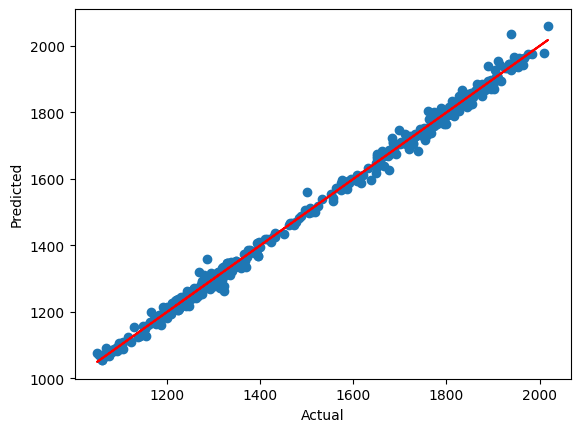

In [12]:
# Plot predictions vs actual values
plt.scatter(y_test,y_pridict)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()



# Evaluation Stage 

In [13]:
# Calculate R² score
r2 = r2_score(y_test,y_pridict)
print(f'R^2 Score: {r2}')

print("Mean Squared Error: ", mean_squared_error(y_test, y_pridict))
print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pridict)))



R^2 Score: 0.9967373592810098
Mean Squared Error:  221.26137471221054
Root Mean Squared Error:  14.874857132497459


# RandomForest using GridSearch

In [14]:
rand= RandomForestRegressor()

param_grid={
    "n_estimators": [100,200,300],
    "max_depth": [None,10,20,30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}

GS=GridSearchCV(estimator=rand, param_grid=param_grid, scoring='r2',verbose=0,n_jobs=-1)
GS.fit(x_train,y_train)

# printing the best parameter and score for the model 
print("Best parameters:", GS.best_params_)
best_rf = GS.best_estimator_

print("Best Score:", GS.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best Score: 0.9965137992876386
